<a href="https://colab.research.google.com/github/dlagur/ProjectHanium/blob/main/CosineSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
    similarity = dot_product/l2_norm

    return similarity

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_sample = TfidfVectorizer()
feature_vect_sample = tfidf_vect_sample.fit_transform(doc_list)
print(feature_vect_sample.shape)

(3, 18)


## TFIDF 벡터화

In [5]:
feature_vect_dense = feature_vect_sample.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

similarity_sample = cos_similarity(vect1, vect2)
print('문장 1과 2의 유사도: {0: .3f}'.format(similarity_sample))

문장 1과 2의 유사도:  0.402


In [6]:
from sklearn.metrics.pairwise import cosine_similarity 
# cosine_similarity() : 두 개의 입력 파라미터(1: 비교 기준 문서 피처 행렬, 2: 비교할 문서 피처 행렬)

similarity_sample_pair = cosine_similarity(feature_vect_sample[0], feature_vect_sample)
print(similarity_sample_pair)

[[1.         0.40207758 0.40425045]]


In [26]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2),
                             min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [37]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'/content/topics'

all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename': filename_list,  'opinion_text': opinion_text})
document_df.head(3)

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster label'] = cluster_label

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

hotel_indexes = document_df[document_df['cluster label']==1].index
print('호텔로 군집화 된 문서들의 DataFrame Index:', hotel_indexes)

comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('### 비교 기준 문서명', comparison_docname, '와 타 문서 유사도 ###')
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame Index: Int64Index([ 1,  2,  4,  5,  6,  7,  9, 14, 17, 21, 23, 24, 25, 27, 32, 40, 41,
            42, 43, 45, 46, 47, 48, 49, 50],
           dtype='int64')
### 비교 기준 문서명 directions_garmin_nuvi_255W_gps 와 타 문서 유사도 ###
[[1.         0.28497799 0.02271738 0.11432497 0.04817064 0.01720395
  0.02261621 0.2644128  0.06161541 0.34657949 0.07303126 0.0302352
  0.0362441  0.02266515 0.06332225 0.02630391 0.15187003 0.02528717
  0.02211323 0.1764187  0.05431799 0.04275113 0.02999396 0.02477727
  0.06016007]]


Text(0.5, 1.0, 'directions_garmin_nuvi_255W_gps')

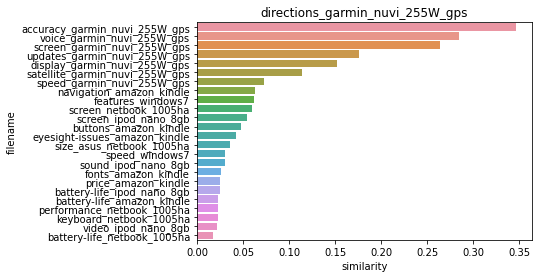

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:] #자기 자신은 제외

hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:] # 자기 자신은 제외

hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)